In [56]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)

In [78]:
train = pd.read_csv('UserBehavior.csv')

In [79]:
train.columns

Index(['1', '2268318', '2520377', 'pv', '1511544070'], dtype='object')

## 检查缺失值

In [4]:
train.isnull().sum()

1             0
2268318       0
2520377       0
pv            0
1511544070    0
dtype: int64

In [80]:
##修改列名称
train.columns = ['user_id','item_id','item_category_id','action','time']

transform unix timestamp to date fomat

In [90]:
train['time'] = pd.to_datetime(train['time'],unit='s',format = "%Y-%m-%d %H:%M:%S")

In [96]:
train['time']

0           2017-11-24 22:15:33
1           2017-11-25 01:21:25
2           2017-11-25 07:04:53
3           2017-11-25 07:49:06
4           2017-11-25 13:28:01
                    ...        
100150801   2017-12-03 09:30:03
100150802   2017-12-03 09:36:06
100150803   2017-12-03 09:36:32
100150804   2017-12-03 09:37:07
100150805   2017-12-03 09:38:11
Name: time, Length: 100150806, dtype: datetime64[ns]

In [97]:
train.action.unique()

array(['pv', 'fav', 'buy', 'cart'], dtype=object)

### 时间戳转换与提取
 - 把日期和时间(小时)单独提取出来

In [105]:
train['time'] = train['time'].apply(str,0)
train["date"] = train['time'].str.split(" ").str[0]

In [1]:
## 删除异常时间

In [119]:
train = train.loc[train["date"].between('2017-11-25' ,'2017-12-03'),:]

In [127]:
train["hour"] = train["time"].str.split(" ").str[1].str.split(":").str[0]
train['hour'] = train['hour'].astype(np.int16)

用户行为分为4种：浏览、收藏、加购、支付，分别对其编码为1，2，3，4

In [129]:
behaviour_code = dict(zip(['pv', 'fav', 'cart', 'buy'],[1,2,3,4]))
train['behaviour_type'] = train["action"].map(behaviour_code)

In [130]:
train.drop(["time","action"],axis = 1,inplace = True)

In [132]:
train

,user_id,item_id,item_category_id,date,hour,behaviour_type
1,1,2576651,149192,2017-11-25,01,1
2,1,3830808,4181361,2017-11-25,07,1
3,1,4365585,2520377,2017-11-25,07,1
4,1,4606018,2735466,2017-11-25,13,1
5,1,230380,411153,2017-11-25,21,1
...,...,...,...,...,...,...
100150801,999999,4797808,11120,2017-12-03,09,1
100150802,999999,4613472,4602841,2017-12-03,09,1
100150803,999999,3647364,2304296,2017-12-03,09,1
100150804,999999,1903801,2304296,2017-12-03,09,1


### 用户行为随时间的变化
DAU and DAUU

In [136]:
pvd = train.groupby('date')['user_id'].count().reset_index(drop = False)
uvd = train.groupby('date')['user_id'].apply(lambda x: x.drop_duplicates().count()).reset_index(drop= False)

In [139]:
pvd = pvd.rename(columns = {"user_id":"pv"})  ##dui tong ji zhiduan jinxing  chong minming
uvd = uvd.rename(columns = {"user_id":"uv"})

In [142]:
date_ticks = ['11-25','11-26','11-27','11-28','11-29','11-30','12-01','12-02','12-03']

Text(0.5, 1.0, 'uv_daily')

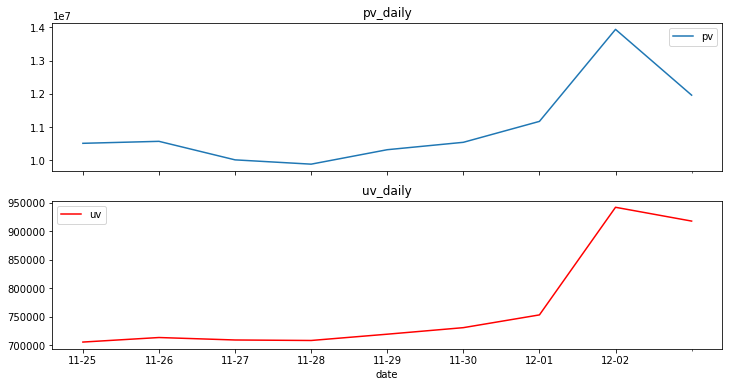

In [150]:
fig,axes = plt.subplots(2,1,figsize=(12,6),sharex=True)
pvd.plot(x="date",y="pv",ax=axes[0])
uvd.plot(x="date",y="uv",ax=axes[1],color = 'r')
plt.xticks(np.arange(8),date_ticks)
axes[0].set_title("pv_daily")
axes[1].set_title("uv_daily")
plt.show()

- 活跃用户(有任何用户行为)的总数在11.30日开始快速上升，可以考虑是由于周末大家空闲时间变多以及天猫双12促销活动开始而引起的

In [375]:
pv_h = train.groupby('hour')['user_id'].count().reset_index(drop = False).rename(columns = {'user_id':'pvh'})
uv_h = train.groupby('hour')['user_id'].apply(lambda x: x.drop_duplicates().count()).reset_index(drop= False).rename(columns = {'user_id':'uvh'})

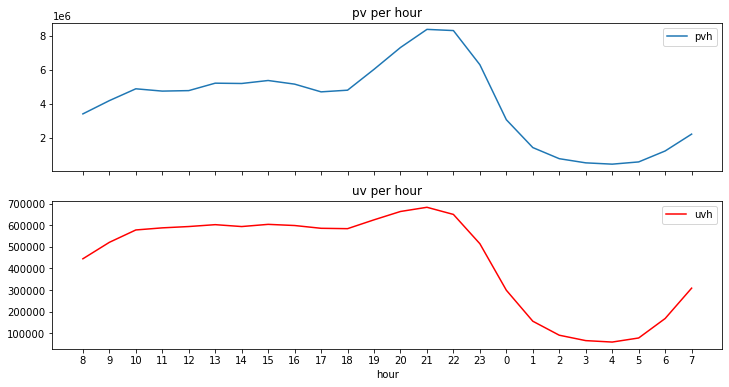

In [376]:
fig,axes = plt.subplots(2,1,figsize=(12,6),sharex=True)
pv_h.plot(x = "hour",y="pvh",ax=axes[0])
uv_h.plot(x = "hour",y="uvh",ax=axes[1],color = 'r')
plt.xticks(np.arange(24), np.hstack((np.arange(8,24),np.arange(0,8))))
axes[0].set_title("pv per hour")
axes[1].set_title("uv per hour")
plt.show()

- 用户在上午10点之后活跃程度逐渐升高，在晚上21点达到最高(这时候大家都比较空闲)，在夜晚23点大家进入休息时间之后快速下降

In [160]:
be_hou_group = train.groupby(["behaviour_type","hour"])['user_id'].count().reset_index().rename(columns = {"user_id":"amount"})

In [162]:
a = be_hou_group[be_hou_group["behaviour_type"] == 1]
b = be_hou_group[be_hou_group["behaviour_type"] == 2]
c = be_hou_group[be_hou_group["behaviour_type"] == 3]
d = be_hou_group[be_hou_group["behaviour_type"] == 4]


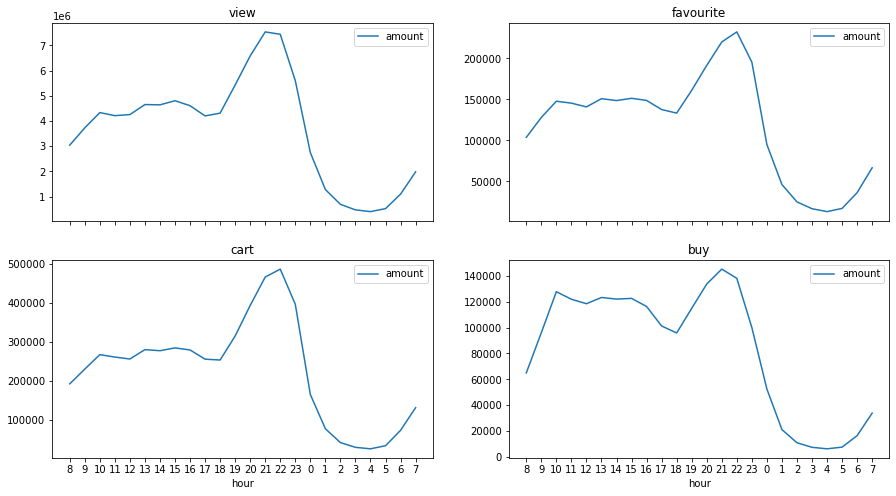

In [188]:
fig,axes = plt.subplots(2,2,figsize=(15,8),sharex=True)
a.plot(x = "hour",y = "amount", ax = axes[0][0],title = "view")
b.plot(x = "hour",y = "amount",ax = axes[0][1],title = "favourite")
c.plot(x = "hour",y = "amount",ax = axes[1][0],title = "cart")
d.plot(x = "hour",y = "amount",ax = axes[1][1],title = 'buy')
plt.xticks(np.arange(24),np.hstack((np.arange(8,24),np.arange(0,8))))
plt.show()

- 我们分别分析4种用户行为在不同时间的活跃程度，大体上4种用户行为随时间的变化与用户活跃情况是差不多的。

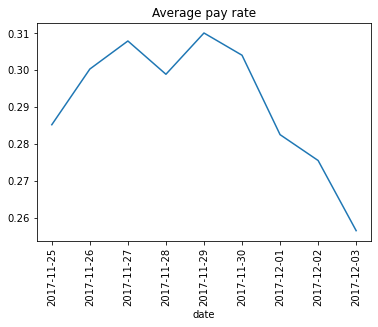

In [207]:
train["operation"] = 1 ##添加一个新列便于进行行为次数的统计
##日平均购买率 = 日购买用户人数 / 日活跃用户人数 
user_buy = train.groupby(["date","user_id","behaviour_type"])["operation"].count().reset_index().rename(columns={"operation":"total"})
user_buy.groupby("date").apply(lambda x: x[x.behaviour_type==4].total.sum()/len(x.user_id.unique())).plot(rot = 90)
plt.title('Average pay rate')
plt.show()

- 发现日平均用户购买率在用户活跃快速增加的11-30日开始快速下降，也就是说促销活动虽然引进了大量的流量，但是流量的转换率并不高。我们通过漏斗分析方法分析其中哪个环节出现问题

## 漏斗分析用户流失情况

In [366]:
data1 = train.loc[train.date.between('2017-12-01','2017-12-03'),:]


In [367]:
step1 = data1.groupby(["behaviour_type"]).count().reset_index()

all1 = data1['user_id'].count()

In [369]:
print("浏览量点击量转化率：{:.4f}\n点击量收藏量转化率：{:.4f}\n收藏量加入购物量转化率：{:.4f}\n加购量购买量转化率：{:.4f}"
      .format(step1.iloc[0,1]/all1
      ,step1.iloc[1,1]/step1.iloc[0,1]
      ,step1.iloc[2,1]/step1.iloc[1,1]
      ,step1.iloc[3,1]/step1.iloc[0,1]))

浏览量点击量转化率：0.8952
点击量收藏量转化率：0.0319
点击量加入购物量转化率：2.0041
点击量购买量转化率：0.0213


- 总共时间段(所记录)的转换率

In [209]:
step = train.groupby(["behaviour_type"]).count().reset_index()

In [210]:
step

,behaviour_type,user_id,item_id,item_category_id,date,hour,operation
0,1,88596903,88596903,88596903,88596903,88596903,88596903
1,2,2852536,2852536,2852536,2852536,2852536,2852536
2,3,5466118,5466118,5466118,5466118,5466118,5466118
3,4,1998976,1998976,1998976,1998976,1998976,1998976


In [212]:
all_ = train["user_id"].count()
all_

98914533

In [213]:
print("浏览量点击量转化率：{:.4f}\n点击量收藏量转化率：{:.4f}\n收藏量加入购物量转化率：{:.4f}\n加购量购买量转化率：{:.4f}"
      .format(step.iloc[0,1]/all_
      ,step.iloc[1,1]/step.iloc[0,1]
      ,step.iloc[2,1]/step.iloc[1,1]
      ,step.iloc[3,1]/step.iloc[0,1]))

浏览量点击量转化率：0.8957
点击量收藏量转化率：0.0322
点击量加入购物量转化率：1.9162
点击量购买量转化率：0.0226


- 我们发现点击到收藏这个步骤的转换率比较低，考虑是否用户推荐环节出现问题，可以优化推荐算法给用户推荐更中意的商品，加购到支付的转化率也比较低，可以考虑优化支付方式，更方便用户实现支付
- 在12-01到12-03期间虽然流量增多了，但是点击到收藏的转化率也下降了，这说明大部分用户只是被营销策略吸引而点进来看一下就退出去了；而且加购到支付的转化率也降低了。

## RFM 分析用户价值

In [220]:
import datetime

In [370]:
data_buy = train[train["behaviour_type"] == 4]

In [233]:
#####取出每个用户最近的购买时间
recent_buy_time = data_buy.groupby(["user_id"]).date.apply(lambda x: x.sortvlues().iloc[-1]).reset_index().rename(columns = {'date':'recent'})
###########用户的最近的购买时间减去数据记录的最早时间，越大说明用户越在最近进行了支付行为
recent_buy_measure = recent_buy_time.recent.str.split('-').apply(lambda x: (datetime.datetime(int(x[0]),int(x[1]),int(x[2])) - datetime.datetime(2017,11,25)).days )
recent_buy_time["measure"] = recent_buy_measure 
##################记录的用户的购买频数，越大越好
buy_freq = train[train["behaviour_type"] == 4].groupby(["user_id"]).date.count()
buy_freq = pd.DataFrame(buy_freq).rename(columns = {'date':'freq'})

In [371]:
recent_buy_time.head()


,user_id,recent,measure
0,2,2017-12-02,7
1,4,2017-11-30,5
2,11,2017-11-25,0
3,16,2017-12-01,6
4,17,2017-12-01,6


In [372]:
buy_freq.head()

,freq
user_id,
2,7
4,4
11,1
16,2
17,1


In [293]:
##将记录R和F的得分的数据框合并
RFM = pd.merge(buy_freq, recent_buy_time, on = ['user_id'], how = 'inner')

In [305]:
##计算R,F得分的平均值，对用户进行划分
r_threshold = np.round(RFM.freq.mean())
f_threshold = np.round(RFM.measure.mean())

In [340]:
RFM['recent_cut'] = RFM.measure.map(lambda x: "2" if x >= r_threshold else  "1")
RFM['freq_cut'] = RFM.freq.map(lambda x: "2" if x>= f_threshold else  "1" )

In [341]:
RFM['rfm'] = RFM['recent_cut'] + RFM['freq_cut']

In [342]:
a1 = RFM[RFM['rfm'] == "22"].shape[0]/RFM.shape[0]
b1 = RFM[RFM['rfm'] == "21"].shape[0]/RFM.shape[0]
c1 = RFM[RFM['rfm'] == "12"].shape[0]/RFM.shape[0]
d1 = RFM[RFM['rfm'] == '11'].shape[0]/RFM.shape[0]


In [2]:
print("{:0.2f} \n{:0.2f} \n{:0.2f} \n{:0.2f}".format(a1, b1, c1, d1))

用户被标记为'22'的是核心用户，具有较强的购买力和忠诚度，占比为0.17；用户被标记为'21'的是忠诚度高但是购买力不够的用户占比最高为0.67，用户被标记为"12"的是忠诚度不够但购买力很强的用户，占比为0.01，需要采取相应策略挽回这部分用户，用户被标记为"11"的是忠诚度不够且购买力也不高的用户，占比为0.15。